In [2]:
import re
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import Dataset, DatasetDict, load_dataset
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
)

## Load dataset

In [3]:
dataset= load_dataset("sonlam1102/vihsd")

train = pd.DataFrame(dataset['train'])

dataset

DatasetDict({
    train: Dataset({
        features: ['free_text', 'label_id'],
        num_rows: 24048
    })
    validation: Dataset({
        features: ['free_text', 'label_id'],
        num_rows: 2672
    })
    test: Dataset({
        features: ['free_text', 'label_id'],
        num_rows: 6680
    })
})

In [6]:
# Load augmented eda data
aug_eda_offensive = pd.read_csv('data/aug_eda_offensive.csv', sep='|')
aug_eda_hate = pd.read_csv('data/aug_eda_hate.csv', sep='|')

# Add to train in dataset
eda_dataset = DatasetDict(dataset)
eda_dataset['train'] = Dataset.from_pandas(
    pd.concat([train, aug_eda_offensive, aug_eda_hate], ignore_index=True)
)
eda_dataset

DatasetDict({
    train: Dataset({
        features: ['free_text', 'label_id'],
        num_rows: 34290
    })
    validation: Dataset({
        features: ['free_text', 'label_id'],
        num_rows: 2672
    })
    test: Dataset({
        features: ['free_text', 'label_id'],
        num_rows: 6680
    })
})

In [7]:
# Load augmented llm data
aug_llm_offensive = pd.read_csv('data/aug_llm_offensive.csv', sep='|')
aug_llm_hate = pd.read_csv('data/aug_llm_hate.csv', sep='|')

# Add to train in dataset
llm_dataset = DatasetDict(dataset)
llm_dataset['train'] = Dataset.from_pandas(
    pd.concat([train, aug_llm_offensive, aug_llm_hate], ignore_index=True)
)
llm_dataset

DatasetDict({
    train: Dataset({
        features: ['free_text', 'label_id'],
        num_rows: 34048
    })
    validation: Dataset({
        features: ['free_text', 'label_id'],
        num_rows: 2672
    })
    test: Dataset({
        features: ['free_text', 'label_id'],
        num_rows: 6680
    })
})

## Preprocessing

In [11]:
EMOTICON_PATH = 'data/convert/emoticon.txt'
TEENCODE_PATH = 'data/convert/teencode.txt'

In [12]:
# Technique 1: Standardizing words
def remove_character(text: str) -> str:
    """Standardize text by removing consecutive characters."""
    return re.sub(r'(.)\1+', r'\1', text)


# Technique 2: Converting emoticons to emojis
emoticon_df = pd.read_csv(EMOTICON_PATH, sep='|', header=None)
emoticon_data = dict(zip(emoticon_df[0], emoticon_df[1]))

def convert_emoticon(text: str) -> str:
    """Convert emoticon to emoji."""
    for k, v in emoticon_data.items():
        text = re.sub(re.escape(k), f' {v} ', text)
    return text


# Technique 3: Convert teencode to complete word
teencode_df = pd.read_csv(TEENCODE_PATH, sep='|', header=None)
teencode_data = dict(zip(teencode_df[0], teencode_df[1]))

def convert_teencode(text: str) -> str:
    """Convert teencode to complete word."""
    for k, v in teencode_data.items():
        text = re.sub(rf'\b{re.escape(k)}\b', f' {v} ', text)
    return text


# Normalize text
emoji_pattern = (
    r'['
    '\U0001f600-\U0001f64f'
    '\U0001f300-\U0001f5ff'
    '\U0001f680-\U0001f6ff'
    '\U0001f1e0-\U0001f1ff'
    '\U00002600-\U000026ff'
    '\U00002700-\U000027bf'
    ']+'
)
tokenize_pattern = re.compile(r'\w+|' + emoji_pattern + r'|[^\s\w]+')


def normalize_text(text: str) -> str:
    """Normalize text with consistent spacing between tokens."""
    return ' '.join(tokenize_pattern.findall(text))

In [13]:
preprocess_methods = {
    '1': remove_character,
    '2': convert_emoticon,
    '3': convert_teencode,
}

def preprocess_text(text: str, methods: list[str], normalize: bool = False) -> str:
    text = str(text)

    for method in methods:
        text = preprocess_methods[method](text)

    if normalize:
        text = normalize_text(text)

    return text

## Model

In [14]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, weight=None, ignore_index=-100) -> None:
        super().__init__()
        self.gamma = gamma
        self.weight = weight
        self.ignore_index = ignore_index

    def forward(self, inputs, targets):
        logits = F.log_softmax(inputs, dim=1)
        pt = torch.exp(logits)
        logits = (1 - pt) ** self.gamma * logits
        loss = F.nll_loss(logits, targets, weight=self.weight, ignore_index=self.ignore_index)
        return loss

    # def forward(self, inputs, targets):
    #     ce_loss = F.cross_entropy(inputs, targets, weight=self.weight, ignore_index=self.ignore_index)
    #     pt = torch.exp(-ce_loss)
    #     loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
    #     return loss


class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss = FocalLoss()(logits, labels)
        return (loss, outputs) if return_outputs else loss


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128, preprocess_methods=[], normalize=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.preprocess_methods = preprocess_methods
        self.normalize = normalize

        self.load_encodings()

    def load_encodings(self):
        self.encodings = []
        for text in self.texts:
            text = preprocess_text(text, self.preprocess_methods, self.normalize)
            encoding = self.tokenizer(
                text, padding='max_length', truncation=True, max_length=self.max_length
            )
            self.encodings.append(encoding)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.encodings[idx]
        label = self.labels[idx]

        return {
            'input_ids': torch.tensor(encoding['input_ids']),
            'attention_mask': torch.tensor(encoding['attention_mask']),
            'labels': torch.tensor(label),
        }

In [15]:
def train(
    dataset: DatasetDict,
    model_name: str,
    max_length: int = 128,
    batch_size: int = 16,
    num_epochs: int = 3,
    learning_rate: float = 2e-5,
    preprocess_methods: list[str] = [],
    normalize: bool = False,
    output_dir: str | None = None,
    device: str = 'cpu',
) -> Trainer:
    if output_dir is None:
        output_dir = f'./results/{time.strftime("%Y%m%d_%H%M%S")}'

    labels = ['CLEAN', 'OFFENSIVE', 'HATE']

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(labels))

    def get_ds(split: str) -> CustomDataset:
        df = pd.DataFrame(dataset[split])
        return CustomDataset(
            df['free_text'],
            df['label_id'],
            tokenizer,
            max_length,
            preprocess_methods,
            normalize,
        )

    train_ds = get_ds('train')
    dev_ds = get_ds('validation')
    test_ds = get_ds('test')

    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=learning_rate,
        warmup_steps=100,
        weight_decay=0.01,
        do_eval=True,
        no_cuda=device == 'cpu',
        logging_steps=200,
        report_to=[],
    )

    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=dev_ds,
    )

    trainer.train()
    trainer.save_model(output_dir)

    y_pred_classify = trainer.predict(test_ds)

    y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
    y_true = test_ds.labels

    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    f1_micro = f1_score(y_true, y_pred, average='micro')
    print(f'F1 - micro: {f1_micro}')

    f1_macro = f1_score(y_true, y_pred, average='macro')
    print(f'F1 - macro: {f1_macro}')

    report = classification_report(y_true, y_pred, target_names=labels)
    print(report)

    # Visualize confusion matrix
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(8, 8))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True') 
    plt.tight_layout()
    plt.show()

    return trainer

## PhoBERT - No Preprocessing - No Augmented Data

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
200,0.228400
400,0.163300
600,0.127400
800,0.115800
1000,0.088500
1200,0.077600
1400,0.057900
1600,0.045600
1800,0.038700


[[5233  167  148]
 [ 189  180   75]
 [ 213  104  371]]
F1 - micro: 0.8658682634730539
F1 - macro: 0.63896753779288
              precision    recall  f1-score   support

       CLEAN       0.93      0.94      0.94      5548
   OFFENSIVE       0.40      0.41      0.40       444
        HATE       0.62      0.54      0.58       688

    accuracy                           0.87      6680
   macro avg       0.65      0.63      0.64      6680
weighted avg       0.86      0.87      0.86      6680



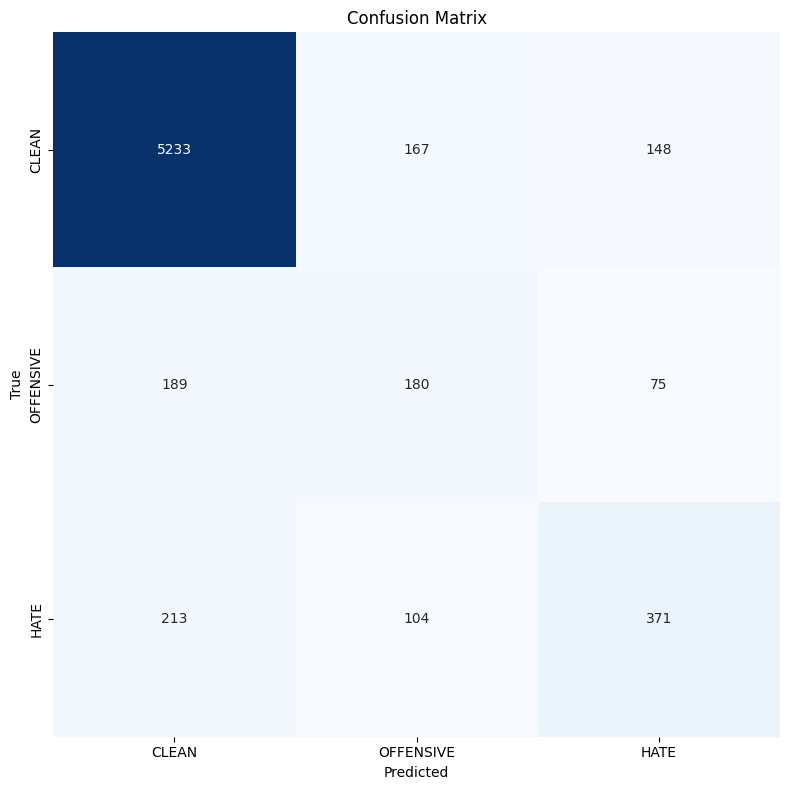

In [14]:
train(
    dataset=dataset,
    model_name='vinai/phobert-base',
    max_length=128,
    batch_size=64,
    num_epochs=5,
    learning_rate=5e-5,
    preprocess_methods=[],
    normalize=False,
    output_dir='./results/phobert/no_pp-no_aug',
    device='cuda' if torch.cuda.is_available() else 'cpu',
)

## PhoBERT - Normalize - No Augmented Data

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
200,0.227700
400,0.160600
600,0.124000
800,0.114200
1000,0.087000
1200,0.073800
1400,0.057600
1600,0.043700
1800,0.037200


[[5232  168  148]
 [ 179  188   77]
 [ 228   87  373]]
F1 - micro: 0.8672155688622755
F1 - macro: 0.6464551716739071
              precision    recall  f1-score   support

       CLEAN       0.93      0.94      0.94      5548
   OFFENSIVE       0.42      0.42      0.42       444
        HATE       0.62      0.54      0.58       688

    accuracy                           0.87      6680
   macro avg       0.66      0.64      0.65      6680
weighted avg       0.86      0.87      0.86      6680



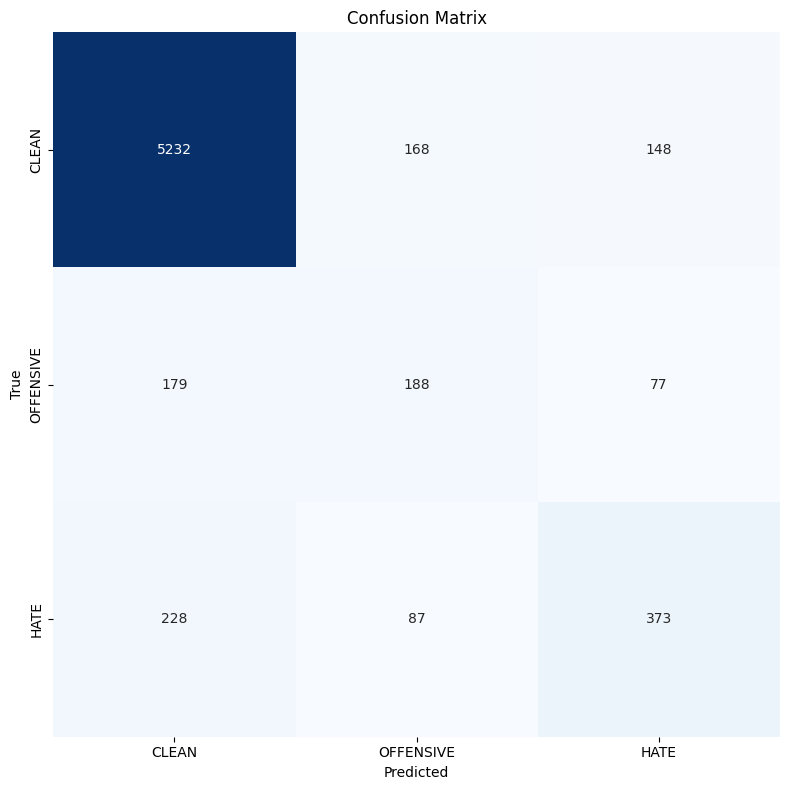

In [15]:
train(
    dataset=dataset,
    model_name='vinai/phobert-base',
    max_length=128,
    batch_size=64,
    num_epochs=5,
    learning_rate=5e-5,
    preprocess_methods=[],
    normalize=True,
    output_dir='./results/phobert/norm-no_aug',
    device='cuda' if torch.cuda.is_available() else 'cpu',
)

## PhoBERT - 1 + Normalize - No Augmented Data

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
200,0.225900
400,0.158900
600,0.124600
800,0.113000
1000,0.086900
1200,0.074300
1400,0.054000
1600,0.043300
1800,0.037100


[[5253  158  137]
 [ 184  193   67]
 [ 218   98  372]]
F1 - micro: 0.8709580838323353
F1 - macro: 0.6528809856017884
              precision    recall  f1-score   support

       CLEAN       0.93      0.95      0.94      5548
   OFFENSIVE       0.43      0.43      0.43       444
        HATE       0.65      0.54      0.59       688

    accuracy                           0.87      6680
   macro avg       0.67      0.64      0.65      6680
weighted avg       0.87      0.87      0.87      6680



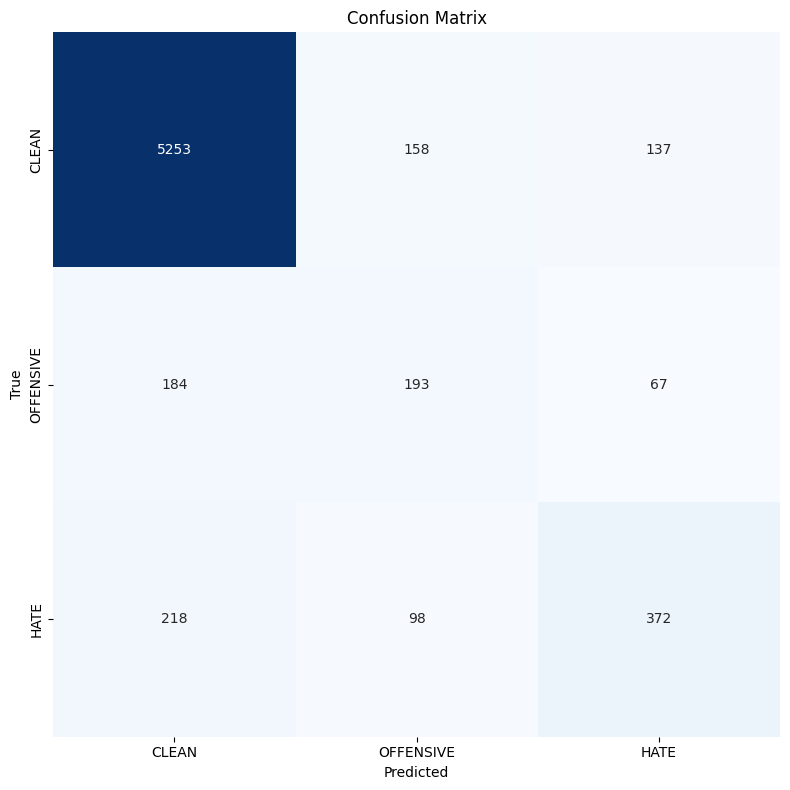

In [15]:
train(
    dataset=dataset,
    model_name='vinai/phobert-base',
    max_length=128,
    batch_size=64,
    num_epochs=5,
    learning_rate=5e-5,
    preprocess_methods=['1'],
    normalize=True,
    output_dir='./results/phobert/1-norm-no_aug',
    device='cuda' if torch.cuda.is_available() else 'cpu',
)

## PhoBERT - 1 + 2 + Normalize - No Augmented Data

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
200,0.229500
400,0.166300
600,0.130300
800,0.118400
1000,0.090200
1200,0.077700
1400,0.060300
1600,0.048800
1800,0.041900


[[5261  142  145]
 [ 191  176   77]
 [ 206   88  394]]
F1 - micro: 0.8729041916167665
F1 - macro: 0.6524577987780815
              precision    recall  f1-score   support

       CLEAN       0.93      0.95      0.94      5548
   OFFENSIVE       0.43      0.40      0.41       444
        HATE       0.64      0.57      0.60       688

    accuracy                           0.87      6680
   macro avg       0.67      0.64      0.65      6680
weighted avg       0.87      0.87      0.87      6680



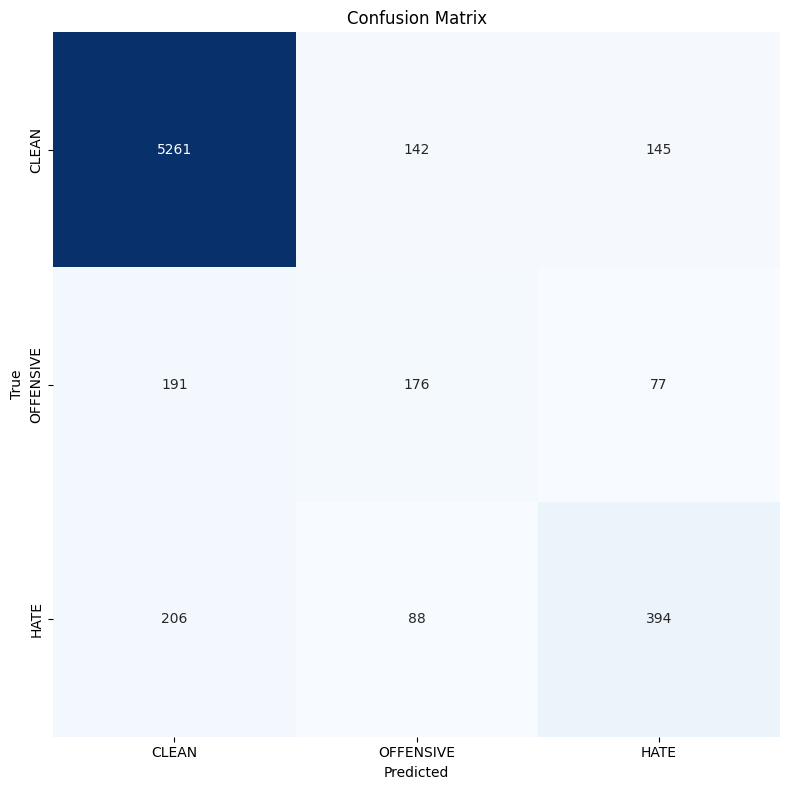

In [16]:
train(
    dataset=dataset,
    model_name='vinai/phobert-base',
    max_length=128,
    batch_size=64,
    num_epochs=5,
    learning_rate=5e-5,
    preprocess_methods=['1', '2'],
    normalize=True,
    output_dir='./results/phobert/1-2-norm-no_aug',
    device='cuda' if torch.cuda.is_available() else 'cpu',
)

## PhoBERT - 1 + 3 + Normalize - No Augmented Data

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
200,0.223300
400,0.160500
600,0.124000
800,0.113900
1000,0.085400
1200,0.073400
1400,0.055200
1600,0.043400
1800,0.035900


[[5276  155  117]
 [ 188  182   74]
 [ 237   85  366]]
F1 - micro: 0.8718562874251496
F1 - macro: 0.6487713565528005
              precision    recall  f1-score   support

       CLEAN       0.93      0.95      0.94      5548
   OFFENSIVE       0.43      0.41      0.42       444
        HATE       0.66      0.53      0.59       688

    accuracy                           0.87      6680
   macro avg       0.67      0.63      0.65      6680
weighted avg       0.86      0.87      0.87      6680



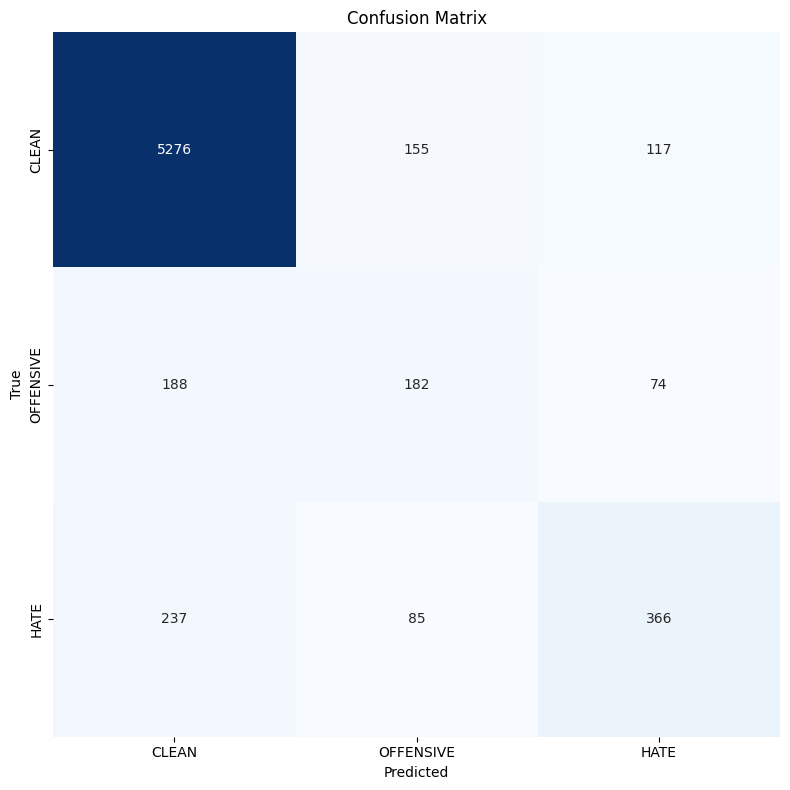

In [15]:
train(
    dataset=dataset,
    model_name='vinai/phobert-base',
    max_length=128,
    batch_size=64,
    num_epochs=5,
    learning_rate=5e-5,
    preprocess_methods=['1', '3'],
    normalize=True,
    output_dir='./results/phobert/1-3-norm-no_aug',
    device='cuda' if torch.cuda.is_available() else 'cpu',
)

## PhoBERT - 1 + 2 + 3 + Normalize - No Augmented Data

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
200,0.224600
400,0.158200
600,0.124900
800,0.113800
1000,0.086300
1200,0.073700
1400,0.055500
1600,0.043800
1800,0.035600


[[5273  138  137]
 [ 194  176   74]
 [ 210   86  392]]
F1 - micro: 0.8744011976047904
F1 - macro: 0.654617603675999
              precision    recall  f1-score   support

       CLEAN       0.93      0.95      0.94      5548
   OFFENSIVE       0.44      0.40      0.42       444
        HATE       0.65      0.57      0.61       688

    accuracy                           0.87      6680
   macro avg       0.67      0.64      0.65      6680
weighted avg       0.87      0.87      0.87      6680



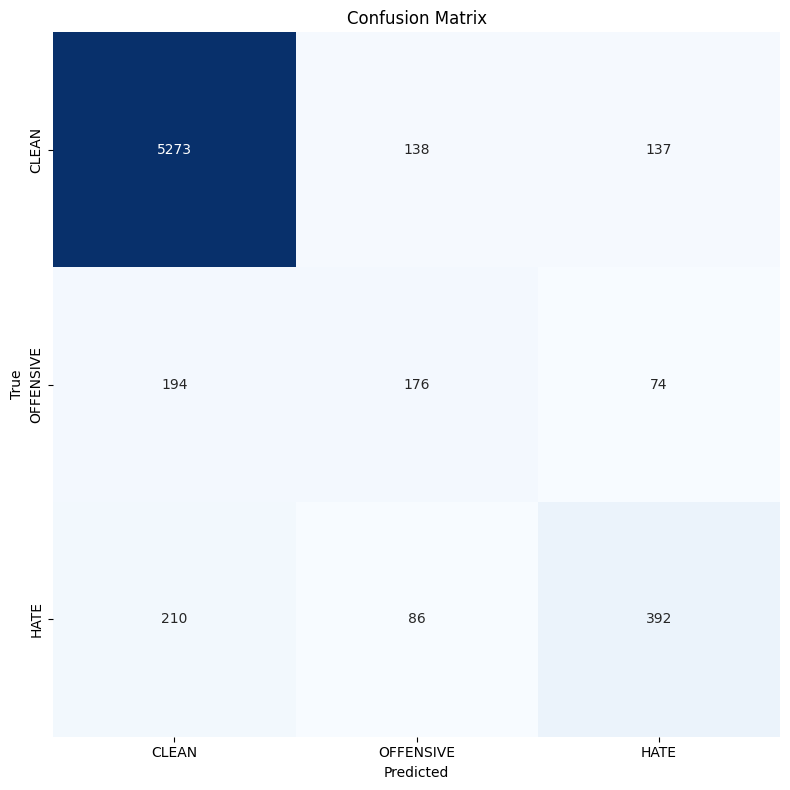

In [17]:
train(
    dataset=dataset,
    model_name='vinai/phobert-base',
    max_length=128,
    batch_size=64,
    num_epochs=5,
    learning_rate=5e-5,
    preprocess_methods=['1', '2', '3'],
    normalize=True,
    output_dir='./results/phobert/1-2-3-norm-no_aug',
    device='cuda' if torch.cuda.is_available() else 'cpu',
)

## PhoBERT - 1 + 2 + 3 + Normalize - EDA Augmented Data

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
200,0.317800
400,0.221100
600,0.179400
800,0.134600
1000,0.118100
1200,0.081200
1400,0.064900
1600,0.063700
1800,0.035500
2000,0.039000


[[5280  130  138]
 [ 218  152   74]
 [ 277   50  361]]
F1 - micro: 0.8672155688622755
F1 - macro: 0.6323096892770333
              precision    recall  f1-score   support

       CLEAN       0.91      0.95      0.93      5548
   OFFENSIVE       0.46      0.34      0.39       444
        HATE       0.63      0.52      0.57       688

    accuracy                           0.87      6680
   macro avg       0.67      0.61      0.63      6680
weighted avg       0.85      0.87      0.86      6680



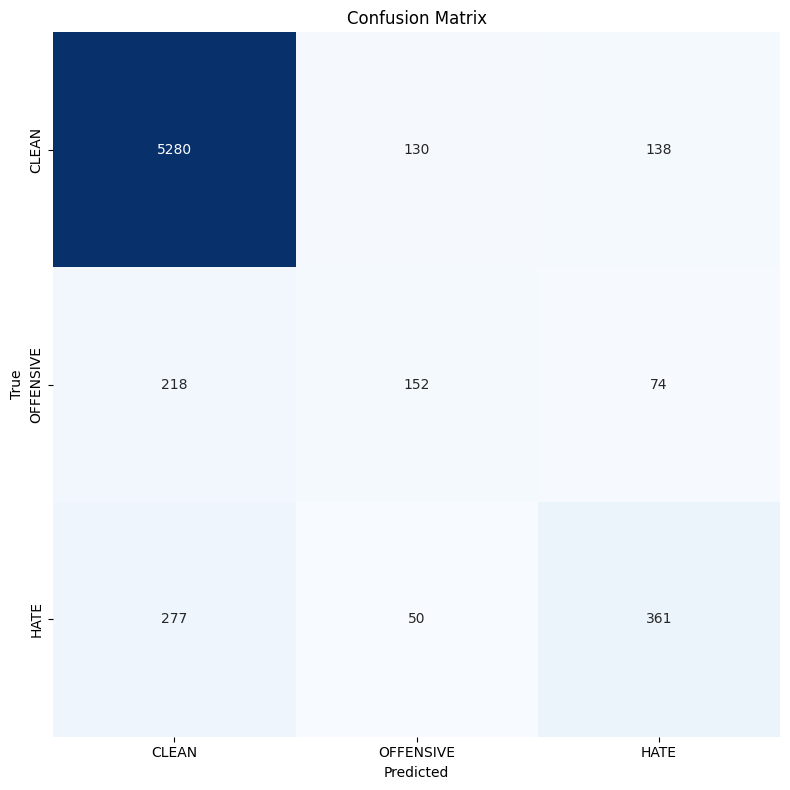

In [20]:
train(
    dataset=eda_dataset,
    model_name='vinai/phobert-base',
    max_length=128,
    batch_size=64,
    num_epochs=5,
    learning_rate=5e-5,
    preprocess_methods=['1', '2', '3'],
    normalize=True,
    output_dir='./results/phobert/1-2-3-norm-eda_data',
    device='cuda' if torch.cuda.is_available() else 'cpu',
)

## PhoBERT - 1 + 2 + 3 + Normalize - LLM Augmented Data

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
200,0.247700
400,0.153200
600,0.133100
800,0.107700
1000,0.110400
1200,0.083200
1400,0.075500
1600,0.072700
1800,0.048000
2000,0.048900


[[5222  182  144]
 [ 178  194   72]
 [ 204  107  377]]
F1 - micro: 0.8672155688622755
F1 - macro: 0.6478902536085032
              precision    recall  f1-score   support

       CLEAN       0.93      0.94      0.94      5548
   OFFENSIVE       0.40      0.44      0.42       444
        HATE       0.64      0.55      0.59       688

    accuracy                           0.87      6680
   macro avg       0.66      0.64      0.65      6680
weighted avg       0.87      0.87      0.87      6680



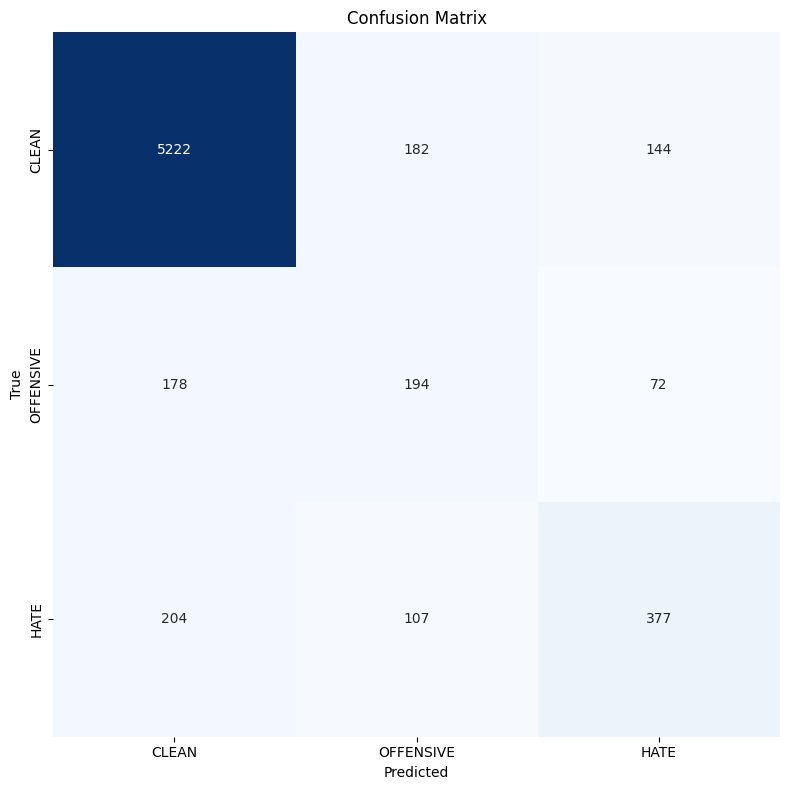

In [21]:
train(
    dataset=llm_dataset,
    model_name='vinai/phobert-base',
    max_length=128,
    batch_size=64,
    num_epochs=5,
    learning_rate=5e-5,
    preprocess_methods=['1', '2', '3'],
    normalize=True,
    output_dir='./results/phobert/1-2-3-norm-llm_data',
    device='cuda' if torch.cuda.is_available() else 'cpu',
)